# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given the known salary for a big set of Job ID listings along with some known (relevant) features, i.e. Company ID, Job Type, Degree, Major, Industry, Years Experience, and Distance from Metropolitan, we would would like to develop a machine learned statistical model to predict the salary for another dataset of Job ID postings with the same features as the ones for jobs having known salaries. In other words, we train our model based on the Job ID dataset with known salaries and, then, test it on the Job ID dataset with unknown salaries. This is a supervised machine learning problem for lots of applications like glassdoor in order to predict salary for any given Job ID, e.g. position.

In [179]:
# Import the neccessary modules for data manipulation, visual representation, and machine learning algorithms
import numpy as np

import scipy as sp
from scipy.sparse import csr_matrix, hstack

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn import model_selection
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, Binarizer, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

from xgboost import XGBClassifier

import seaborn as sns
import random
import math
import time
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#your info here
__author__ = "Ashoordin Ashoormaram"
__email__ = "a.ashoormaram@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----
Import the data (make sure you update this on a daily basis if applicable for the corresponding business problem)

In [180]:
#load the data into a Pandas dataframe
#training data
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')

#testing data
test = pd.read_csv('data/test_features.csv')

In [181]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [182]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [251]:
train = pd.merge(train_features, train_salaries, on='jobId')
# Examine the dataset
train.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 3 Clean the data ----

In [185]:
# Check to see if there is any missing data in the dataset
train.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [186]:
# Check the type of our features. Are there any data inconsistencies?
train.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [187]:
# look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

#Check to see if there are any missing values in our dataset
train.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [188]:
#Check for duplicate data
train.duplicated().any()

False

In [189]:
#Check for invalid data (salaries <=0)
invalid_salary = sum(n <= 0 for n in train.salary)
print("invalid_salary:", invalid_salary)

#Check for invalid data (milesFromMetropolis <0)
invalid_milesFromMetropolis = sum(n < 0 for n in train.milesFromMetropolis)
print("invalid_milesFromMetropolis:", invalid_milesFromMetropolis)

#Check for invalid data (yearsExperience <0)
invalid_yearsExperience = sum(n < 0 for n in train.yearsExperience)
print("invalid_yearsExperience:", invalid_yearsExperience)

invalid_salary: 5
invalid_milesFromMetropolis: 0
invalid_yearsExperience: 0


In [190]:
#Check those data with 0 values of salaries
#query = 0
train.query('salary == %d' %0)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [191]:
#what fraction of data have "NONE" jobId
jobId_none = sum(n=='NONE' for n in train.jobId)
print("jobId_none:", jobId_none)

#what fraction of data have "NONE" companyId
companyId_none = sum(n=='NONE' for n in train.companyId)
print("companyId_none:", companyId_none)

#what fraction of data have "NONE" jobType
jobType_none = sum(n=='NONE' for n in train.jobType)
print("jobType_none:", jobType_none)

#what fraction of data have "NONE" degree
degree_none = sum(n=='NONE' for n in train.degree)
print("degree_none:", degree_none)

#what fraction of data have "NONE" majors
major_none = sum(n=='NONE' for n in train.major)
print("major_none:", major_none)

#what fraction of data have "NONE" industry
industry_none = sum(n=='NONE' for n in train.industry)
print("industry_none:", industry_none)

jobId_none: 0
companyId_none: 0
jobType_none: 0
degree_none: 236854
major_none: 532355
industry_none: 0


In [217]:
# Get names of indexes for which column salary has value 0
indexNames = train[ train['salary'] == 0 ].index

# Delete these row indexes from dataFrame
train_data = train.copy()
train_data.drop(indexNames, inplace=True)
train_data.reset_index(drop=True, inplace=True)

print('train_data shape:', train_data.shape)
print('\n')
train_data.tail(5)

train_data shape: (999995, 9)




,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


### ---- 4 Explore the data (EDA) ----

summarize each feature variable
summarize the target variable
look for correlation between each feature and the target
look for correlation between features

In [193]:
# Finding count of distinct elements in DataFrame in each feature and target
train_data.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

In [194]:
# Showing distinct elements in DataFrame in each feature and target
companyId_uniqueValues = train_data['companyId'].unique()
jobType_uniqueValues = train_data['jobType'].unique()
degree_uniqueValues = train_data['degree'].unique()
major_uniqueValues = train_data['major'].unique()
industry_uniqueValues = train_data['industry'].unique()
yearsExperience_uniqueValues = train_data['yearsExperience'].unique()
milesFromMetropolis_uniqueValues = train_data['milesFromMetropolis'].unique()
salary_uniqueValues = train_data['salary'].unique()

print('companyId_uniqueValues:\n', companyId_uniqueValues)
print('\n')
print('jobType_uniqueValues:\n', jobType_uniqueValues)
print('\n')
print('degree_uniqueValues:\n', degree_uniqueValues)
print('\n')
print('major_uniqueValues:\n', major_uniqueValues)
print('\n')
print('industry_uniqueValues:\n', industry_uniqueValues)
print('\n')
print('yearsExperience_uniqueValues:\n', yearsExperience_uniqueValues)
print('\n')
print('milesFromMetropolis_uniqueValues:\n', milesFromMetropolis_uniqueValues)
print('\n')
print('salary_uniqueValues:\n', salary_uniqueValues)

companyId_uniqueValues:
 ['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']


jobType_uniqueValues:
 ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']


degree_uniqueValues:
 ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']


major_uniqueValues:
 ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']


industry_uniqueValues:
 ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


yearsExperience_uni

In [195]:
#conver object type columns to categorical features
# ['jobId', companyId', 'jobType', 'degree', 'major', 'industry'] are all categorical features where
# 'degree' and 'jobType' should be encoded as ordinal because of the importance of order while 
# the rest should be encoded as onehot because of its non-ordinal nature
for col in ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']:
    train_data[col] = train_data[col].astype('category')
train_data.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [196]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:           9761        5795        2378         234        1587        3434
Swap:             0           0           0


In [223]:
# Summarize statistical description of salary for each feature
train_data.groupby('companyId')['salary'].describe()
train_data.groupby('jobType')['salary'].describe()
train_data.groupby('degree')['salary'].describe()
train_data.groupby('major')['salary'].describe()
train_data.groupby('industry')['salary'].describe()
train_data.groupby('yearsExperience')['salary'].describe()
train_data.groupby('milesFromMetropolis')['salary'].describe()

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP0,15666.0,115.963615,38.604597,20.0,89.0,114.0,141.0,285.0
COMP1,15820.0,116.048609,38.424871,20.0,89.0,114.0,141.0,292.0
COMP10,15909.0,116.019800,38.782127,24.0,89.0,114.0,141.0,278.0
COMP11,15872.0,116.113029,38.623401,20.0,88.0,114.0,141.0,286.0
COMP12,15783.0,116.086485,38.697106,20.0,89.0,114.0,141.0,281.0
...,...,...,...,...,...,...,...,...
COMP61,15822.0,116.318607,38.543621,19.0,89.0,114.0,141.0,275.0
COMP62,15943.0,116.279872,39.177694,20.0,88.0,114.0,141.0,286.0
COMP7,15767.0,115.888501,38.549674,20.0,88.0,114.0,141.0,275.0


,count,mean,std,min,25%,50%,75%,max
jobType,,,,,,,,
CEO,124778.0,145.311425,34.423846,55.0,120.0,142.0,167.0,298.0
CFO,124369.0,135.458547,33.069203,51.0,111.0,132.0,156.0,301.0
CTO,125045.0,135.481067,33.090947,51.0,111.0,132.0,156.0,301.0
JANITOR,124971.0,70.813045,24.643021,17.0,52.0,68.0,86.0,189.0
JUNIOR,124592.0,95.333087,29.246759,23.0,74.0,92.0,114.0,248.0
MANAGER,125120.0,115.368518,30.833865,37.0,93.0,112.0,135.0,270.0
SENIOR,125886.0,105.487775,30.069722,31.0,83.0,102.0,124.0,258.0
VICE_PRESIDENT,125234.0,125.368630,31.956295,44.0,102.0,122.0,146.0,272.0


,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
BACHELORS,175495.0,125.454663,35.042720,35.0,100.0,122.0,148.0,294.0
DOCTORAL,175362.0,135.490979,35.790555,45.0,109.0,132.0,158.0,301.0
HIGH_SCHOOL,236975.0,101.921085,36.112684,18.0,75.0,99.0,125.0,260.0
MASTERS,175310.0,130.505647,35.399830,38.0,105.0,127.0,153.0,301.0
NONE,236853.0,98.176882,34.915141,17.0,72.0,95.0,121.0,254.0


,count,mean,std,min,25%,50%,75%,max
major,,,,,,,,
BIOLOGY,58379.0,127.932664,34.820141,35.0,103.0,125.0,150.0,285.0
BUSINESS,58518.0,135.648980,37.006526,40.0,109.0,132.0,159.0,294.0
CHEMISTRY,58875.0,129.072085,34.832396,40.0,104.0,126.0,151.0,282.0
COMPSCI,58382.0,132.075605,34.776640,41.0,107.0,129.0,154.0,286.0
ENGINEERING,58594.0,138.441342,38.178934,41.0,111.0,135.0,163.0,301.0
LITERATURE,58684.0,124.423097,33.576413,37.0,100.0,122.0,146.0,271.0
MATH,57800.0,133.322042,35.539246,39.0,107.0,130.0,156.0,280.0
NONE,532353.0,102.583864,36.136268,17.0,76.0,100.0,126.0,270.0
PHYSICS,58410.0,130.372436,34.956981,38.0,105.0,127.0,153.0,293.0


,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
AUTO,142941.0,109.435222,36.091590,25.0,84.0,108.0,133.0,264.0
EDUCATION,142819.0,99.448386,35.110257,17.0,75.0,98.0,122.0,253.0
FINANCE,142866.0,130.747659,38.319820,36.0,103.0,128.0,156.0,294.0
HEALTH,142755.0,115.735540,36.865179,28.0,89.0,114.0,140.0,275.0
OIL,142770.0,130.953863,38.528558,37.0,103.0,128.0,156.0,301.0
SERVICE,142639.0,104.446820,35.577606,22.0,79.0,103.0,128.0,256.0
WEB,143205.0,121.645362,38.165659,31.0,94.0,119.0,146.0,290.0


,count,mean,std,min,25%,50%,75%,max
yearsExperience,,,,,,,,
0,39839.0,91.873541,32.383526,17.0,69.0,91.0,113.5,227.0
1,40264.0,93.962373,32.506167,18.0,71.0,93.0,116.0,223.0
2,40045.0,96.125184,32.495476,19.0,73.0,95.0,118.0,229.0
3,40190.0,98.092809,33.026186,21.0,74.0,97.0,120.0,234.0
4,40036.0,100.014112,33.398430,21.0,76.0,99.0,122.0,245.0
5,40013.0,101.681154,33.537491,22.0,78.0,100.0,124.0,245.0
6,40094.0,103.924278,33.708699,21.0,80.0,103.0,127.0,239.0
7,40047.0,106.045022,33.829418,25.0,82.0,105.0,129.0,244.0
8,40118.0,107.838601,34.351790,25.0,83.0,107.0,131.0,248.0


,count,mean,std,min,25%,50%,75%,max
milesFromMetropolis,,,,,,,,
0,10123.0,135.571175,41.096969,29.0,106.0,134.0,163.0,301.0
1,10091.0,135.494203,41.307148,29.0,106.0,133.0,162.0,298.0
2,10031.0,134.930615,41.274564,32.0,105.5,133.0,162.0,292.0
3,10106.0,134.737582,40.662330,31.0,106.0,133.0,162.0,301.0
4,10001.0,134.839916,41.109698,29.0,105.0,133.0,162.0,288.0
...,...,...,...,...,...,...,...,...
95,10125.0,98.025580,32.977865,19.0,74.0,97.0,120.0,226.0
96,10090.0,97.224579,33.063803,18.0,74.0,96.0,119.0,219.0
97,10155.0,97.620876,33.304169,20.0,74.0,96.0,120.0,218.0


In [224]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:           9761        6378        1804         223        1578        2861
Swap:             0           0           0


yearsExperience            AxesSubplot(0.08,0.125;0.255882x0.755)
milesFromMetropolis    AxesSubplot(0.387059,0.125;0.255882x0.755)
salary                 AxesSubplot(0.694118,0.125;0.255882x0.755)
dtype: object

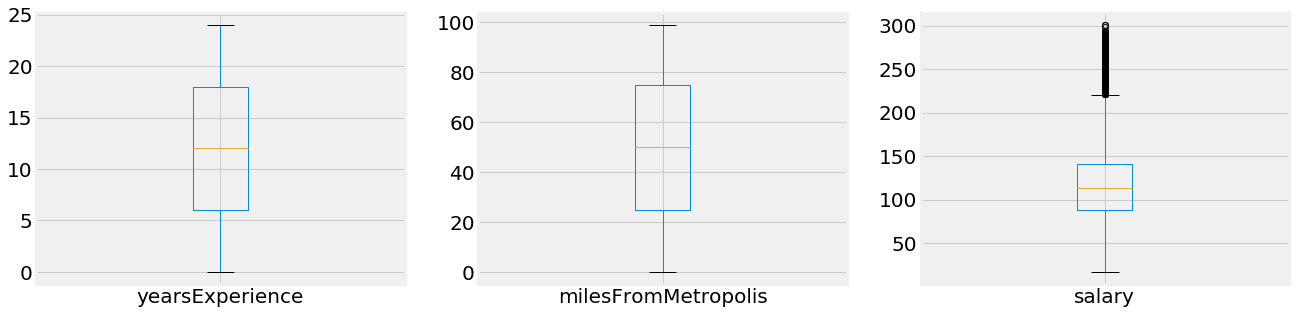

In [225]:
# Box and Whisker Plots of numerical features
train_data.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(20,5), fontsize=20)
plt.show()

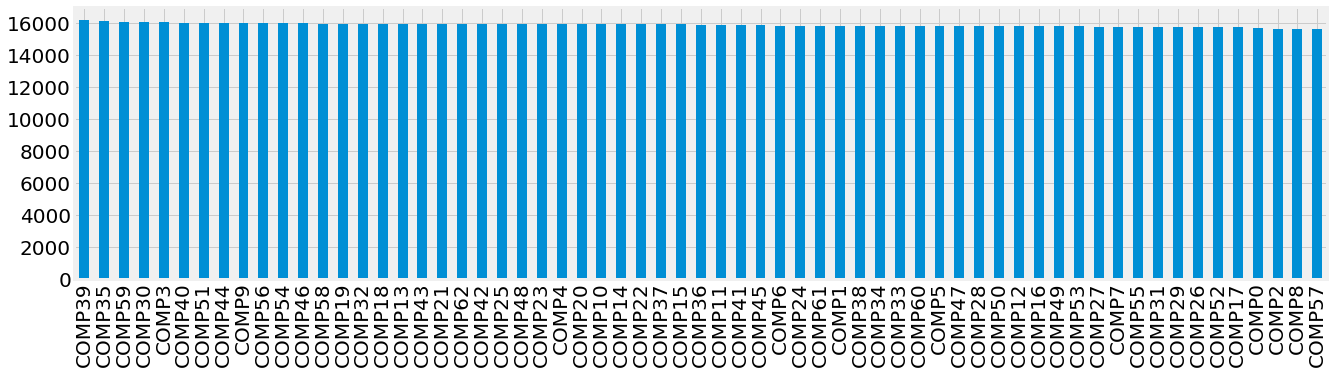

In [226]:
# Bar Plot of companyId
train_data.companyId.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

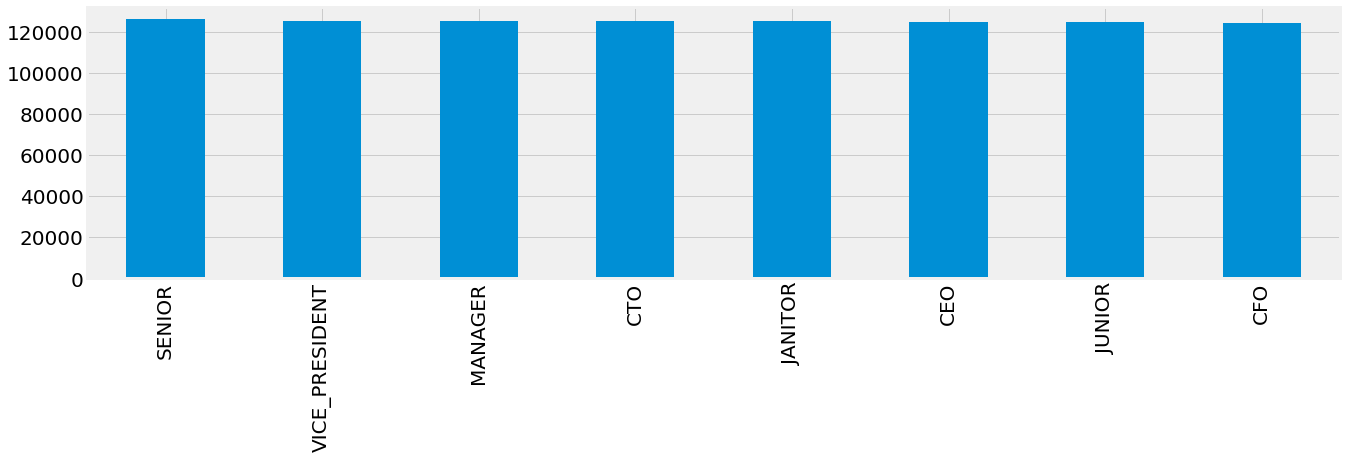

In [227]:
# Bar Plot of jobType
train_data.jobType.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

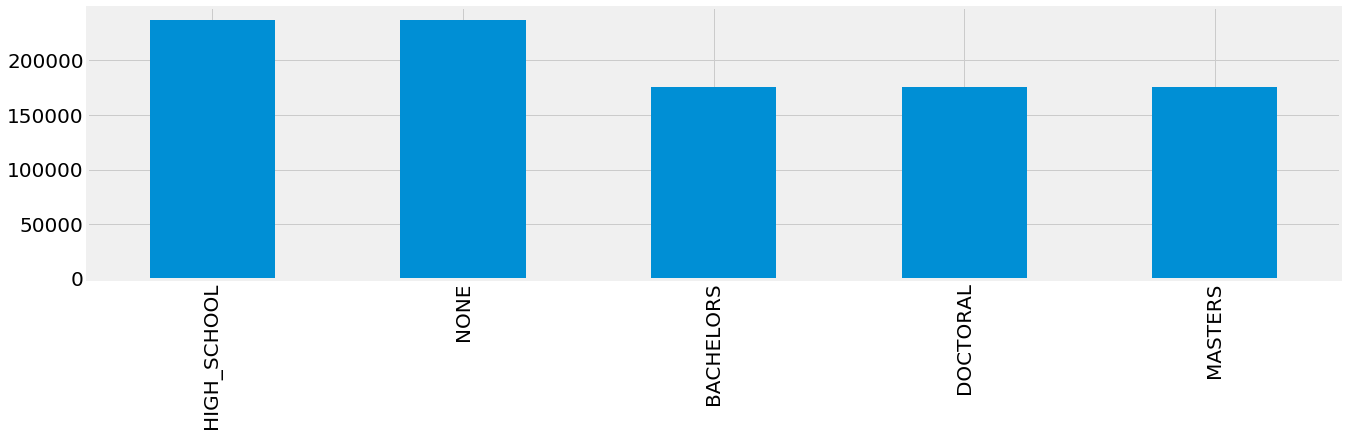

In [228]:
# Bar Plot of degree
train_data.degree.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

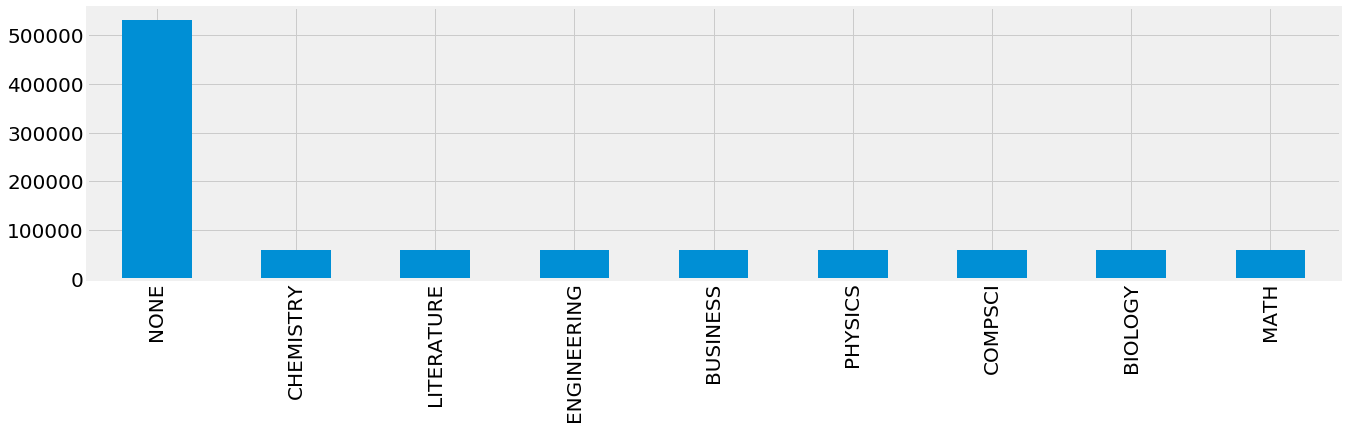

In [229]:
# Bar Plot of major
train_data.major.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

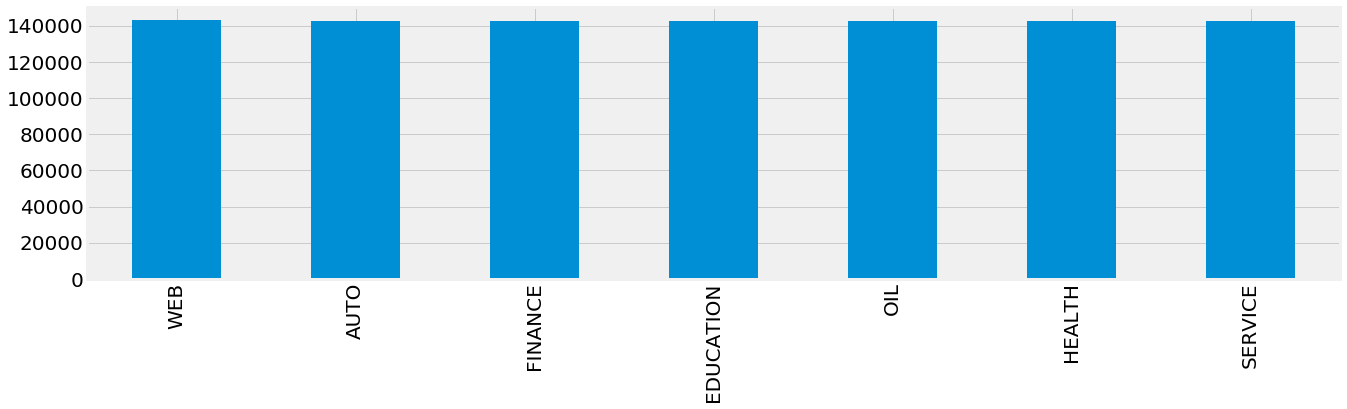

In [230]:
# Bar Plot of industry
train_data.industry.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

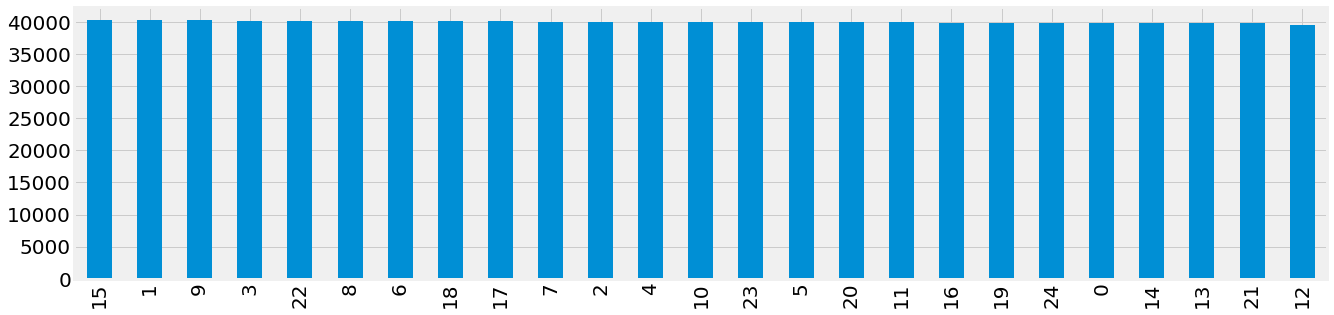

In [231]:
# Bar Plot of yearsExperience
train_data.yearsExperience.value_counts().plot(kind='bar', figsize=(20,5), fontsize=20)

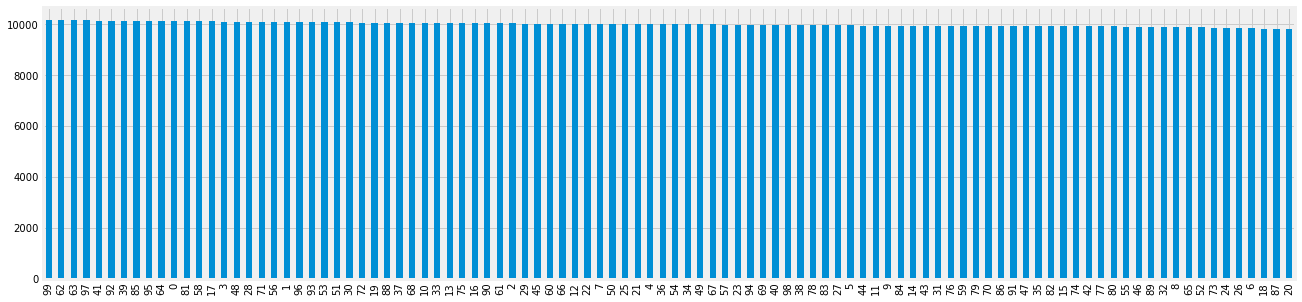

In [232]:
# Bar Plot of milesFromMetropolis
train_data.milesFromMetropolis.value_counts().plot(kind='bar', figsize=(20,5), fontsize=10)

Text(0.5, 1.0, 'salary')

Text(0.5, 1.0, 'salary')

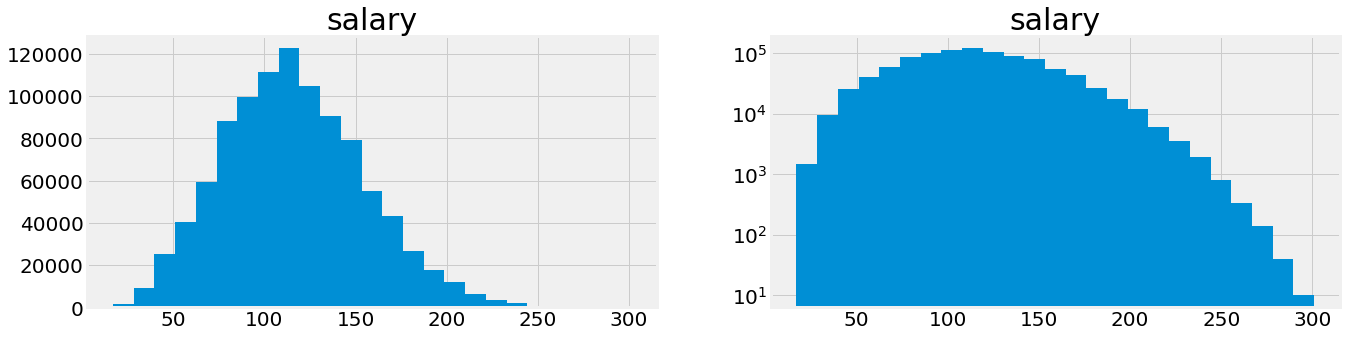

In [233]:
# Histogram Plots of salary
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,5))

train_data.salary.hist(ax=ax1, bins=25, xlabelsize=20, ylabelsize=20)
ax1.set_title('salary', fontsize=30)

train_data.salary.hist(ax=ax2, bins=25, xlabelsize=20, ylabelsize=20)
ax2.set_yscale('log')
ax2.set_title('salary', fontsize=30)

Text(0.5, 1, 'Heatmap of Correlation Matrix')

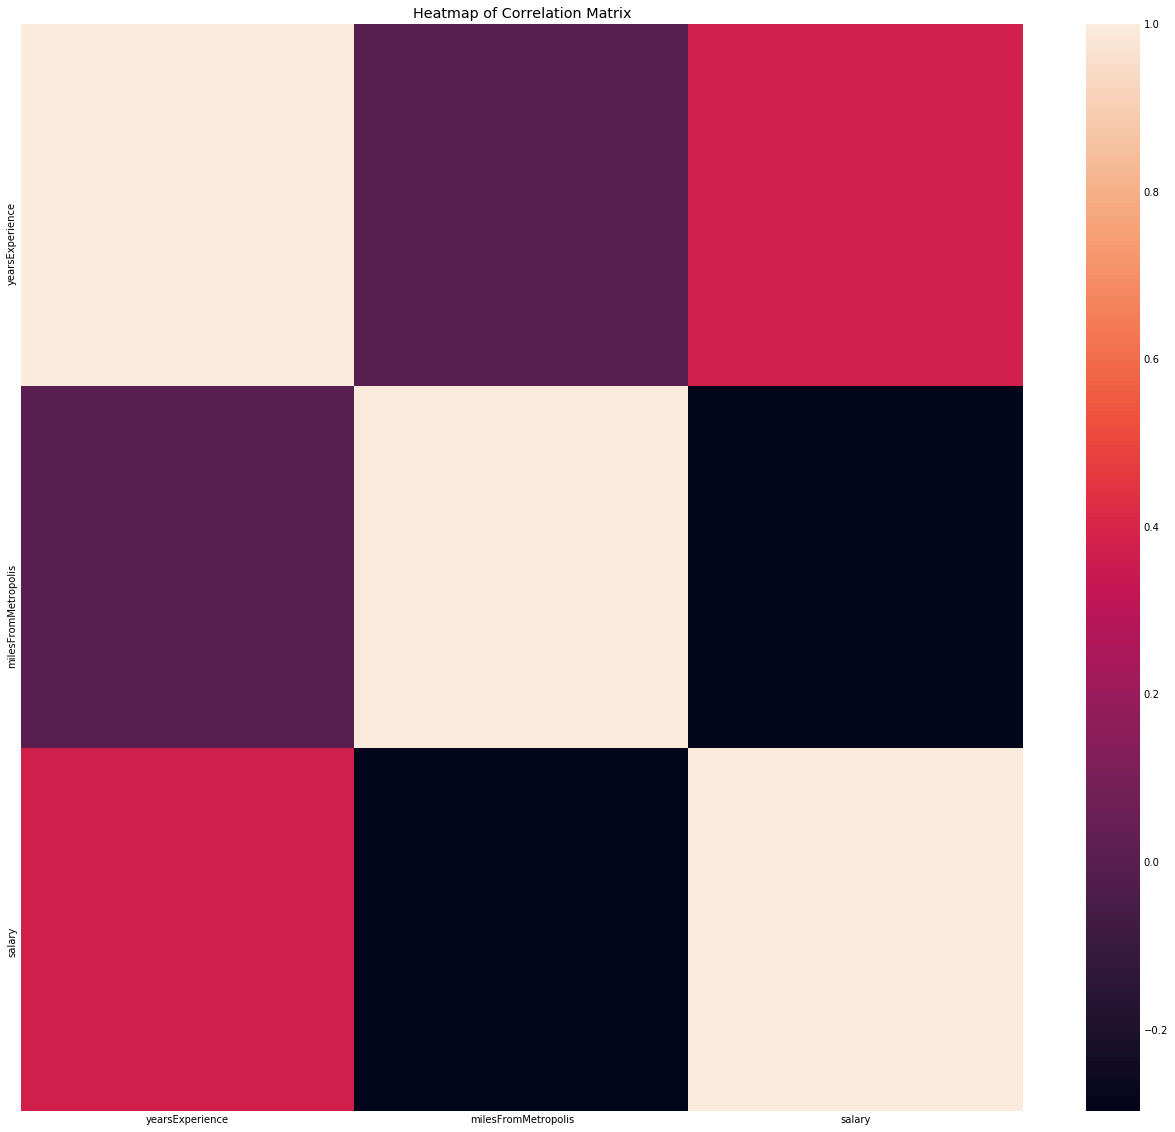

In [234]:
# Now we can get the correlation between the 'salary' and all the other features. 
# Create a correlation matrix. What features correlate the most with salary? What other correlations did you find?
# Make sure to specify some features that you might want to focus on or the plots might be too big
sns.heatmap(train_data.corr(), 
            xticklabels=train_data.corr().columns.values,
            yticklabels=train_data.corr().columns.values)
plt.title('Heatmap of Correlation Matrix')

In [235]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:           9761        6373        1809         223        1578        2866
Swap:             0           0           0


In [236]:
# Feature Engineering to convert categorical data to numerical values either through onehot encoding or label encoding

train_data_NonEngineered = train_data.copy()
#train_data_Engineered = train_data_Engineered_ohe.copy()
# replace oridinal categorical features in place
replace_map = {'degree': {'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS': 4, 'DOCTORAL': 5}, 
               'jobType': {'JANITOR':1, 'JUNIOR':2, 'SENIOR':3, 'MANAGER':4, 'VICE_PRESIDENT':5, 'CFO':6, 'CTO':7, 'CEO':8}
              }
train_data_NonEngineered.replace(replace_map, inplace=True)


train_data_NonEngineered = train_data_NonEngineered.copy()
# generate binary values using get_dummies to onehot encode the non-ordinal categorical features
dum_df = pd.get_dummies(train_data_NonEngineered, columns=['companyId', 'major', 'industry'], prefix=["companyId", "major", "industry"])



# merge with main train_data_engineered dum_df on key values
train_data_Engineered = pd.merge(train_data_NonEngineered, dum_df, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis', 'salary'], how='right').drop(columns=['companyId', 'major', 'industry'])

#taking salary "target" to the end of table
columnsName = list(train_data_Engineered.columns)
salary, last = columnsName.index('salary'), columnsName.index(columnsName[-1])
columnsName[salary], columnsName[last] = columnsName[last],columnsName[salary]
train_data_Engineered = train_data_Engineered[columnsName]

print('engineered dataset shape:\n', train_data_Engineered.shape)
print('\n')
train_data_Engineered.info()

engineered dataset shape:
 (999995, 85)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999994
Data columns (total 85 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                999995 non-null  object
 1   jobType              999995 non-null  int64 
 2   degree               999995 non-null  int64 
 3   yearsExperience      999995 non-null  int64 
 4   milesFromMetropolis  999995 non-null  int64 
 5   industry_WEB         999995 non-null  uint8 
 6   companyId_COMP0      999995 non-null  uint8 
 7   companyId_COMP1      999995 non-null  uint8 
 8   companyId_COMP10     999995 non-null  uint8 
 9   companyId_COMP11     999995 non-null  uint8 
 10  companyId_COMP12     999995 non-null  uint8 
 11  companyId_COMP13     999995 non-null  uint8 
 12  companyId_COMP14     999995 non-null  uint8 
 13  companyId_COMP15     999995 non-null  uint8 
 14  companyId_COMP16     999995 non-null  uint

Text(0.5, 1, 'Heatmap of Correlation Matrix')

,jobType,degree,yearsExperience,milesFromMetropolis,industry_WEB,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,salary
jobType,1.000000,0.201779,0.001061,-0.000212,0.000290,-0.000585,0.000808,-0.000476,0.000143,0.001049,...,0.054368,-0.204651,0.055088,-0.001080,-0.000845,0.000739,-0.000647,0.001993,-0.000451,0.578922
degree,0.201779,1.000000,0.000217,0.001785,-0.000051,-0.000302,0.001470,0.000054,0.000538,-0.001340,...,0.206369,-0.779355,0.207568,0.000911,-0.000483,0.000295,0.001023,0.000599,-0.002294,0.384044
yearsExperience,0.001061,0.000217,1.000000,0.000672,-0.000233,0.001448,-0.001586,-0.002013,0.000515,0.000859,...,-0.000005,0.000110,-0.000269,-0.001002,0.000436,0.000977,-0.001106,0.000801,0.000128,0.375013
milesFromMetropolis,-0.000212,0.001785,0.000672,1.000000,-0.000935,0.001367,-0.000602,-0.000280,0.000701,0.001146,...,-0.000912,-0.001626,0.000221,0.000345,0.000807,0.000050,-0.000400,-0.000550,0.000685,-0.297686
industry_WEB,0.000290,-0.000051,-0.000233,-0.000935,1.000000,-0.000355,0.000720,-0.000417,0.000549,-0.001563,...,-0.000297,0.000177,0.000613,-0.166961,-0.166878,-0.166910,-0.166835,-0.166845,-0.166756,0.058953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
industry_FINANCE,0.000739,0.000295,0.000977,0.000050,-0.166910,-0.000510,0.001325,0.001556,-0.000219,-0.000020,...,0.000665,-0.000696,-0.001168,-0.166731,-0.166648,1.000000,-0.166604,-0.166614,-0.166525,0.154853
industry_HEALTH,-0.000647,0.001023,-0.001106,-0.000400,-0.166835,-0.000631,0.001686,-0.001282,0.001194,-0.000301,...,0.000805,-0.000925,0.000910,-0.166655,-0.166572,-0.166604,1.000000,-0.166539,-0.166450,-0.003445
industry_OIL,0.001993,0.000599,0.000801,-0.000550,-0.166845,0.001573,-0.002214,0.000815,-0.001579,0.001253,...,0.000843,0.000719,-0.000234,-0.166665,-0.166582,-0.166614,-0.166539,1.000000,-0.166460,0.156966
industry_SERVICE,-0.000451,-0.002294,0.000128,0.000685,-0.166756,-0.000014,0.000400,0.000863,-0.001143,0.000154,...,-0.001931,0.001177,0.000066,-0.166576,-0.166493,-0.166525,-0.166450,-0.166460,1.000000,-0.122370


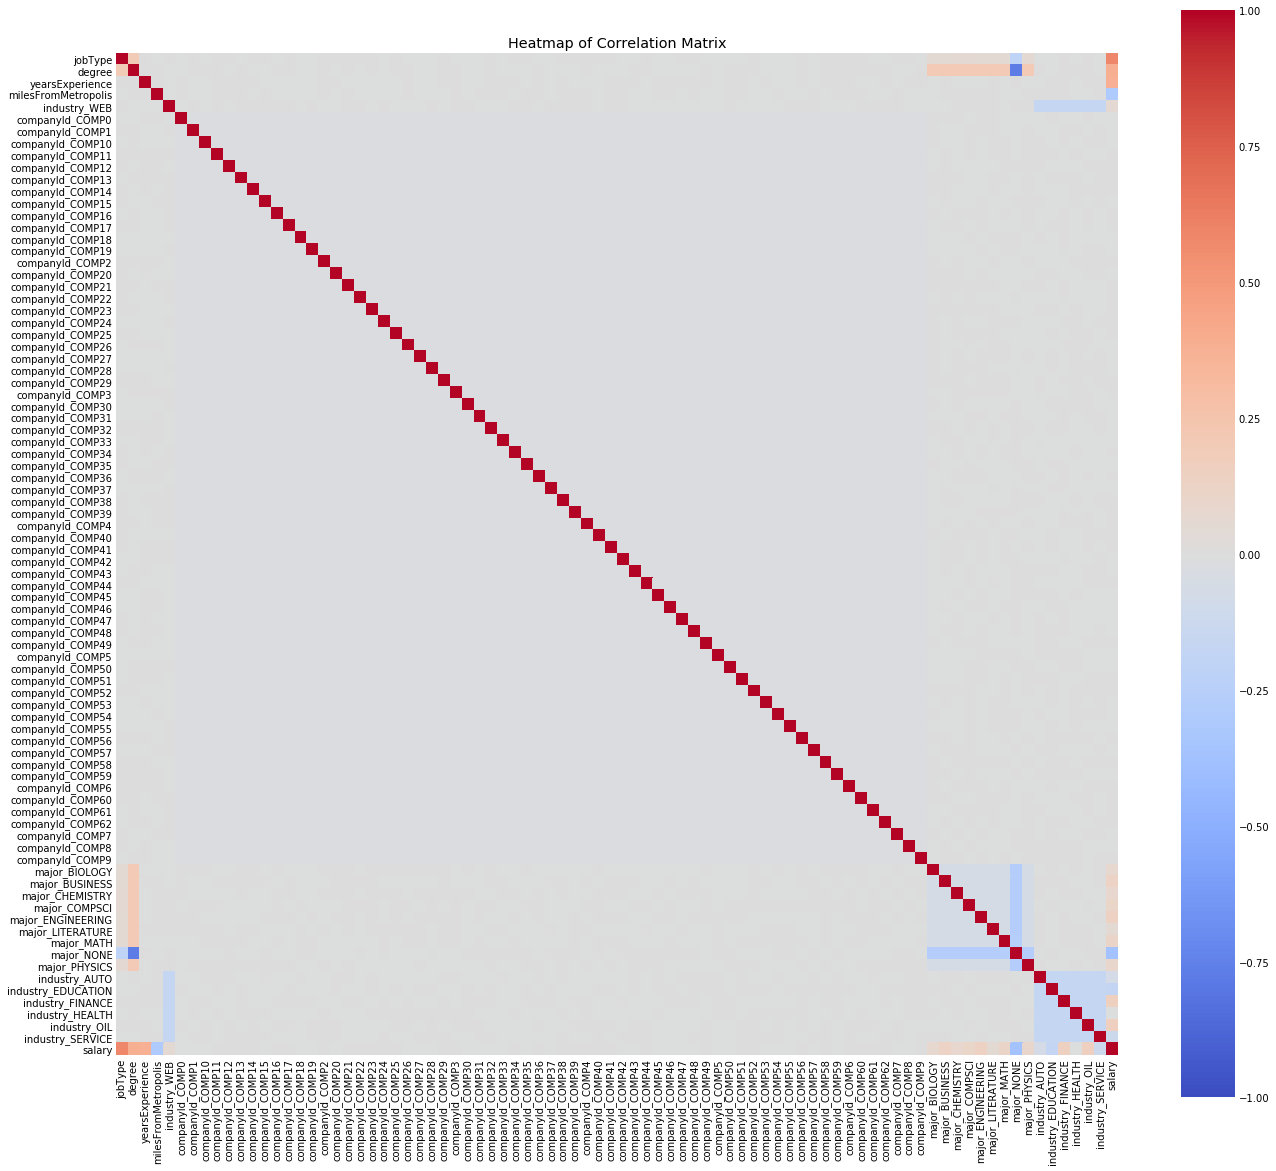

In [237]:
train_data_Engineered_num = train_data_Engineered.select_dtypes(include=np.number)

# Create a correlation matrix. What features correlate the most with salary? What other correlations did you find?
corr_Engineered_num = train_data_Engineered_num.corr()
plt.rcParams['figure.figsize'] = (20, 20)
#matrix = np.triu(corr_Engineered_num)
sns.heatmap(corr_Engineered_num, 
            xticklabels=corr_Engineered_num.columns.values, 
            yticklabels=corr_Engineered_num.columns.values,
            vmin=-1, vmax=1, center= 0, square=True, cmap= 'coolwarm', 
            #annot = True, mask=matrix, cbar_kws= {'orientation': 'horizontal'}
           )
plt.title('Heatmap of Correlation Matrix')
corr_Engineered_num

In [238]:
train_data_Engineered.tail()

,jobId,jobType,degree,yearsExperience,milesFromMetropolis,industry_WEB,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,salary
999990,JOB1362685407682,5,3,19,94,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,88
999991,JOB1362685407683,7,2,12,35,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,160
999992,JOB1362685407684,2,2,16,81,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,64
999993,JOB1362685407685,6,4,6,5,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,149
999994,JOB1362685407686,2,3,20,11,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,88


In [239]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:           9761        6405        1774         225        1581        2831
Swap:             0           0           0


### ---- 5 Establish a baseline ----

In [247]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy

trained = train_data.copy()
# baseline algorithm for regression
def baseline_algorithm_regression(train, test):
    output_values = train_data['salary'].values
        
    industry = trained.groupby('industry')['salary'].mean().to_dict()
    for key in industry:
        trained.loc[trained.industry == key, "salary"] = int(round(industry[key]))
        
    predicted = trained['salary'].values
    MSE = mean_squared_error(output_values,predicted)
    return 'True Values={}\nPredicted Values={}\nMean Squared Error={}'.format(output_values, predicted, MSE)
 
random.seed(1)
predictions = baseline_algorithm_regression(train_data, test)
print(predictions)

True Values=[130 101 137 ...  64 149  88]
Predicted Values=[116 122 116 ...  99 116  99]
Mean Squared Error=1367.244614223071


In [255]:
train_data.tail()
trained.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,116
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,131
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,99
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,116
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,99


In [268]:
# For our baseline model, I use "average salary" for each industry as my model and then measure MSE during 5-fold cross-validation
industry = train_data.groupby('industry')['salary'].mean().to_dict()
for key in industry:
    trained.loc[trained.industry == key, "salary"] = int(round(industry[key]))


    
    
    
train_data_base = trained.copy()
train_data_base.replace(replace_map, inplace=True)
train_data_base = train_data_base.copy()

dum_df = pd.get_dummies(train_data_base, columns=['companyId', 'major', 'industry'], prefix=["companyId", "major", "industry"])
train_data_Engineered_base = pd.merge(train_data_base, dum_df, on=['jobId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis', 'salary'], how='right').drop(columns=['companyId', 'major', 'industry'])

#taking salary "target" to the end of table
columnsName_base = list(train_data_Engineered_base.columns)
salary_base, last_base = columnsName_base.index('salary'), columnsName_base.index(columnsName_base[-1])
columnsName_base[salary], columnsName_base[last] = columnsName_base[last],columnsName_base[salary]
train_data_Engineered_base = train_data_Engineered_base[columnsName_base]

# Creating the modeled version of the real training data
data = train_data_Engineered_base.values
salary_data   = data[:,1:len(train_data_Engineered_base.columns)-1] 
salary_target = data[:,len(train_data_Engineered_base.columns)-1]
validation_size = 0.20

# Test options and evaluation metric
seed = 1
#scoring = make_scorer(mean_squared_error)
data_train, data_validation, target_train, target_validation = train_test_split(
    salary_data, salary_target, test_size=validation_size, random_state=seed)

baseline = LinearRegression(n_jobs=-1)
scores = cross_val_score(baseline, data_train, target_train, cv=5, scoring=make_scorer(mean_squared_error))
print("Cross-validation scores: {}".format(scores))

baseline.fit(data_train, target_train)
print("Training set score: {:.3f}".format(baseline.score(data_train, target_train)))
print("Validation set score: {:.3f}".format(baseline.score(data_validation, target_validation)))

Cross-validation scores: [1.71194378e-26 1.40031070e-26 4.10270946e-27 9.15640488e-27
 1.30307661e-26]


LinearRegression(n_jobs=-1)

Training set score: 1.000
Validation set score: 1.000


### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 
# "CompanyId" feature hardly ever matters (from the scatter matrix above), so we can make a final engineered 
# version of train and test data to make the model simple. We would then avoid implementing the average salary per 
# "industry" to make the model more robust and apply the same "LinearRegression" on these train and test data and
# check for MSE measure of accuracy

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data